## Importing

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import salishsea_tools.viz_tools as sa_vi

from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from sklearn.metrics import mean_squared_error as mse


## Datasets Preparation

In [2]:
def datasets_preparation ():
    
    temp_i1 = (ds.votemper.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
               [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]

    temp_i2 = (ds.votemper.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
               [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

    saline_i1 = (ds.vosaline.where(mask==1)[0,0:15] * ds.e3t.where(mask==1)
                 [0,0:15]).sum('deptht', skipna = True, min_count = 15) / mesh.gdepw_0[0,15]

    saline_i2 = (ds.vosaline.where(mask==1)[0,15:27] * ds.e3t.where(mask==1)
                 [0,15:27]).sum('deptht', skipna = True, min_count = 12) / (mesh.gdepw_0[0,27] - mesh.gdepw_0[0,14])

    sil_i = (ds_bio.silicon.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
             [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    nitr_i = (ds_bio.nitrate.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    ammo_i = (ds_bio.ammonium.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    diat_i = (ds_bio.diatoms.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    flag_i = (ds_bio.flagellates.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]
    
    micro_i = (ds_bio.microzooplankton.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
               [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    meso_i = (ds_bio.mesozooplankton.where(mask==1)[0,0:27] * ds.e3t.where(mask==1)
              [0,0:27]).sum('deptht', skipna = True, min_count = 27) / mesh.gdepw_0[0,27]

    return (temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, diat_i,  flag_i, micro_i, meso_i)


## Regressor

In [3]:
def regressor (inputs, targets, variable_name):

    # Pre processing 
    indx = np.where(~np.isnan(inputs).any(axis=0))
    inputs2 = inputs[:,indx[0]]
    inputs2 = inputs2.transpose()

    targets2 = np.ravel(targets)
    targets2 = targets2[indx[0]]
    
    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs2)
    X_train, X_test, y_train, y_test = train_test_split(inputs2, targets2, random_state=1)
    regr = MLPRegressor(hidden_layer_sizes = 100, activation = 'relu', solver = 'adam', max_iter=1500, random_state=1, learning_rate_init=0.01).fit(X_train, y_train)
    outputs_test = regr.predict(X_test)
    outputs = regr.predict(inputs2)

    scatter_plot(y_test, outputs_test, variable_name + ' (Testing dataset)')

    # Post processing
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[0]] = outputs
    model = np.reshape(indx2,(898,398)) 

    # Preparation of the dataarray 
    model = xr.DataArray(model,
                    coords = {'y': temp_i1.y, 'x': temp_i1.x},
                    dims = ['y','x'],
                    attrs=dict( long_name = variable_name + " Concentration",
                                units="mmol m-2"),
                        )

    plotting(targets2, model, targets, variable_name)

    return (regr)

# Printing

In [4]:
def printing (targets, outputs, m):

    print ('The slope of the best fitting line is ', np.round(m,3))
    print ('The correlation coefficient is:', np.round(np.corrcoef(targets, outputs)[0][1],3))
    print (' The mean square error is:', np.round(mse(targets,outputs),5))


## Scatter Plot

In [5]:
def scatter_plot(targets, outputs, variable_name):

    # compute slope m and intercept b
    m, b = np.polyfit(targets, outputs, deg=1)

    printing (targets, outputs, m)
    
    fig, ax = plt.subplots()

    plt.scatter(targets,outputs, alpha = 0.2, s = 10)
    plt.xlabel('targets')
    plt.ylabel('outputs')

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # plot fitted y = m*x + b
    plt.axline(xy1=(0, b), slope=m, color='r')

    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)

    ax.plot(lims, lims,linestyle = '--',color = 'k')

    fig.suptitle(str(date.date[0]) + ', ' + variable_name)

    plt.show()


# Plotting

In [6]:
def plotting (targets, model, variable, variable_name):

    fig, ax = plt.subplots(2,2, figsize = (10,15))

    cmap = plt.get_cmap('cubehelix')
    cmap.set_bad('gray')

    variable.plot(ax=ax[0,0], cmap=cmap, vmin = targets.min(), vmax =targets.max(), cbar_kwargs={'label': variable_name + ' Concentration  [mmol m-2]'})
    model.plot(ax=ax[0,1], cmap=cmap, vmin = targets.min(), vmax = targets.max(), cbar_kwargs={'label': variable_name + ' Concentration  [mmol m-2]'})
    ((variable-model) / variable * 100).plot(ax=ax[1,0], cmap=cmap, cbar_kwargs={'label': variable_name + ' Concentration  [percentage]'})

    plt.subplots_adjust(left=0.1,
        bottom=0.1, 
        right=0.95, 
        top=0.95, 
        wspace=0.35, 
        hspace=0.35)

    sa_vi.set_aspect(ax[0,0])
    sa_vi.set_aspect(ax[0,1])
    sa_vi.set_aspect(ax[1,0])


    ax[0,0].title.set_text(variable_name + ' (targets)')
    ax[0,1].title.set_text(variable_name + ' (outputs)')
    ax[1,0].title.set_text('targets - outputs')
    ax[1,1].axis('off')

    fig.suptitle(str(date.date[0]))

    plt.show()
    

# Regressor for Other Days

In [7]:
def regressor2 (inputs,targets, variable_name, reg_variable):
    
    # Pre processing 
    indx = np.where(~np.isnan(inputs).any(axis=0))
    inputs2 = inputs[:,indx[0]]
    inputs2 = inputs2.transpose()

    targets2 = np.ravel(targets)
    targets2 = targets2[indx[0]]

    # Regressor
    scale = preprocessing.StandardScaler()
    inputs2 = scale.fit_transform(inputs2)
    outputs = reg_variable.predict(inputs2)

    # Post processing
    indx2 = np.full(inputs[0,:].size,np.nan)
    indx2[indx[0]] = outputs
    model = np.reshape(indx2,(898,398)) 
    
    scatter_plot(targets2,outputs,variable_name)

    # Preparation of the dataarray 
    model = xr.DataArray(model,
                    coords = {'y': temp_i1.y, 'x': temp_i1.x},
                    dims = ['y','x'],
                    attrs=dict( long_name = variable_name + " Concentration",
                                units="mmol m-2"),
                        )

    plotting(targets2, model, targets, variable_name)
                  
    return ()

## Main Body

The slope of the best fitting line is  0.854
The correlation coefficient is: 0.953
 The mean square error is: 0.00064


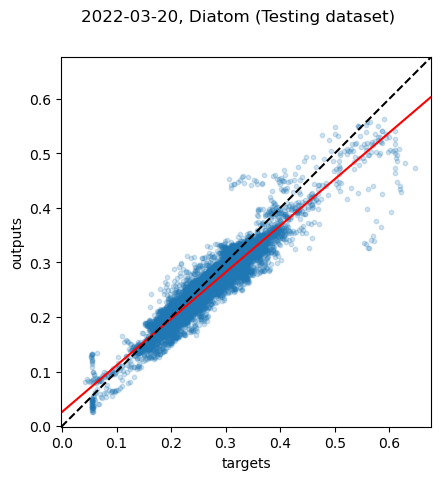

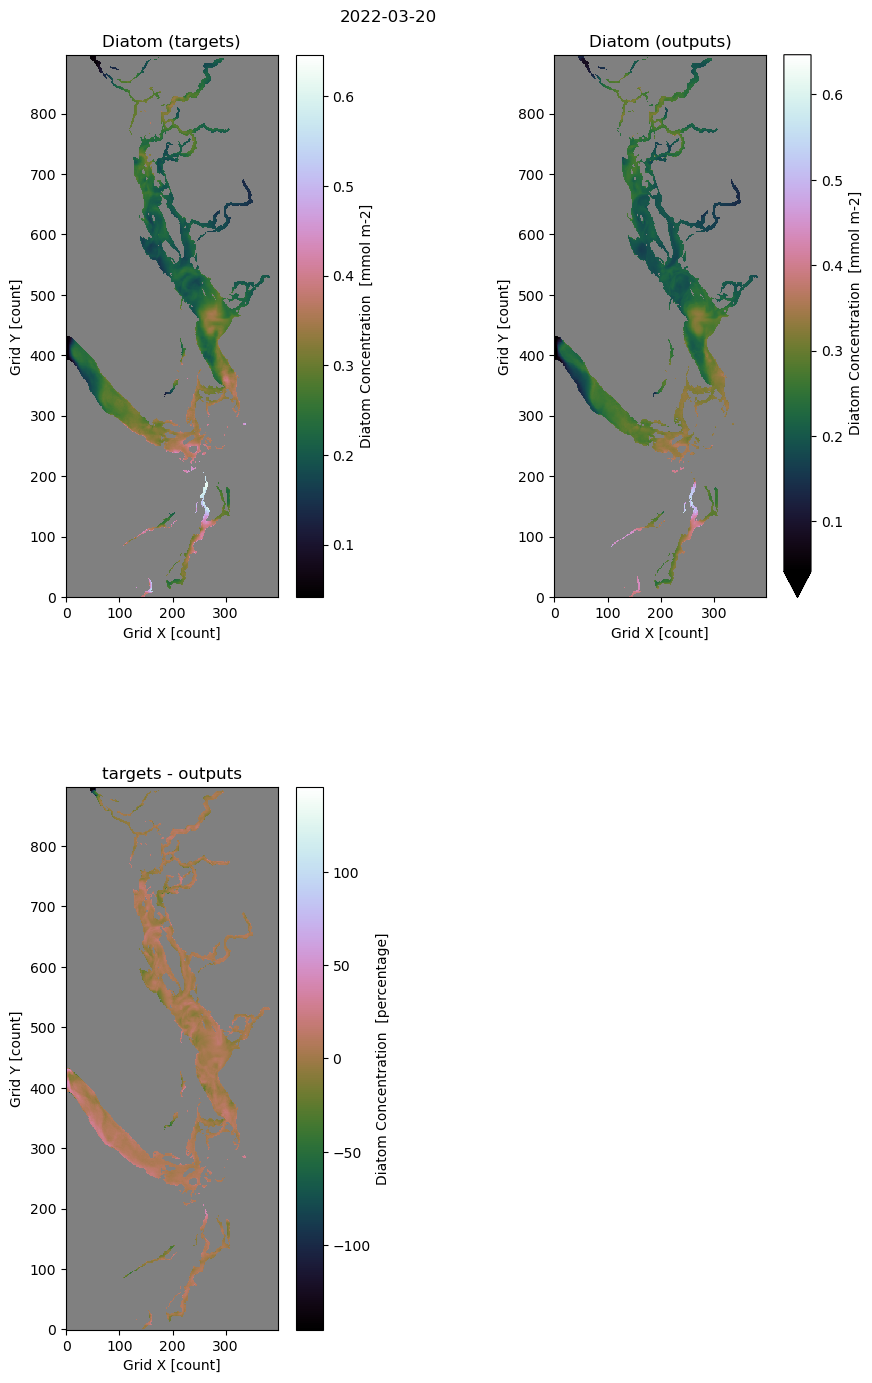

The slope of the best fitting line is  0.976
The correlation coefficient is: 0.977
 The mean square error is: 2e-05


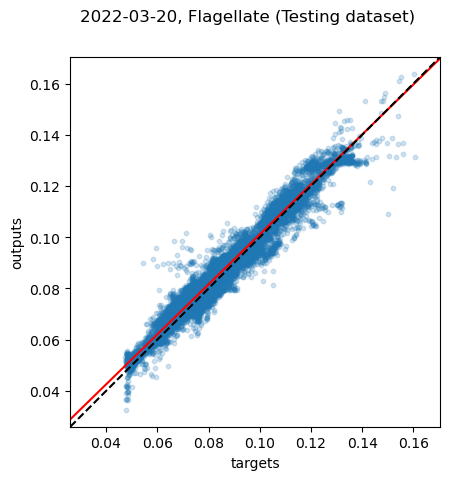

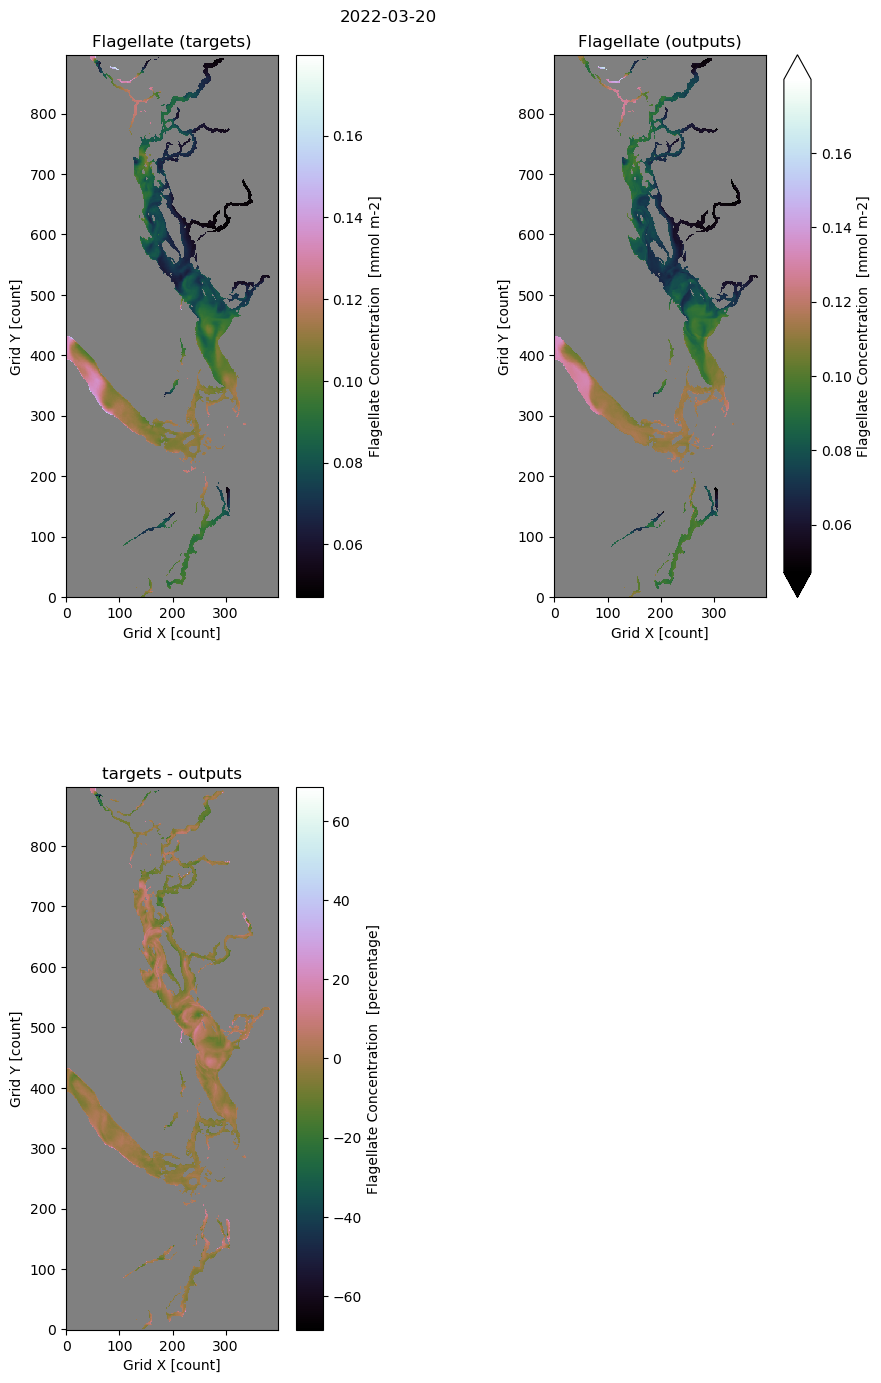

In [8]:
# Dataset and date
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/20mar22/SalishSea_1d_20220320_20220320_biol_T.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)

# Open the mesh mask
mesh = xr.open_dataset('/home/sallen/MEOPAR/grid/mesh_mask202108.nc')
mask = mesh.tmask.to_numpy()

temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, diat_i, flag_i, micro_i, meso_i = datasets_preparation()

# Potential input variables
drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
nutrients = np.stack([np.ravel(sil_i), np.ravel(nitr_i), np.ravel(ammo_i)])
phyto = np.stack([np.ravel(diat_i), np.ravel(flag_i)])
zoo = np.stack([np.ravel(micro_i), np.ravel(meso_i)])

reg_diat = regressor(drivers, diat_i, 'Diatom')
reg_flag = regressor(drivers, flag_i, 'Flagellate')


# Next Day

The slope of the best fitting line is  0.823
The correlation coefficient is: 0.91
 The mean square error is: 0.00082


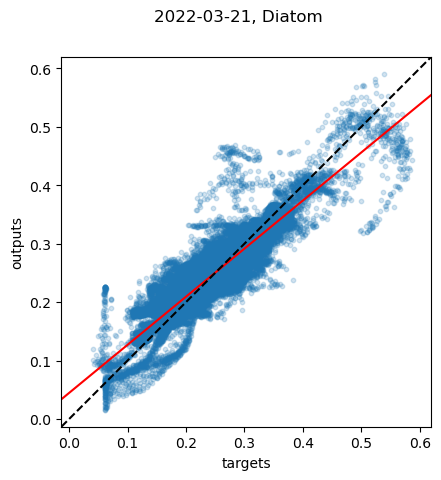

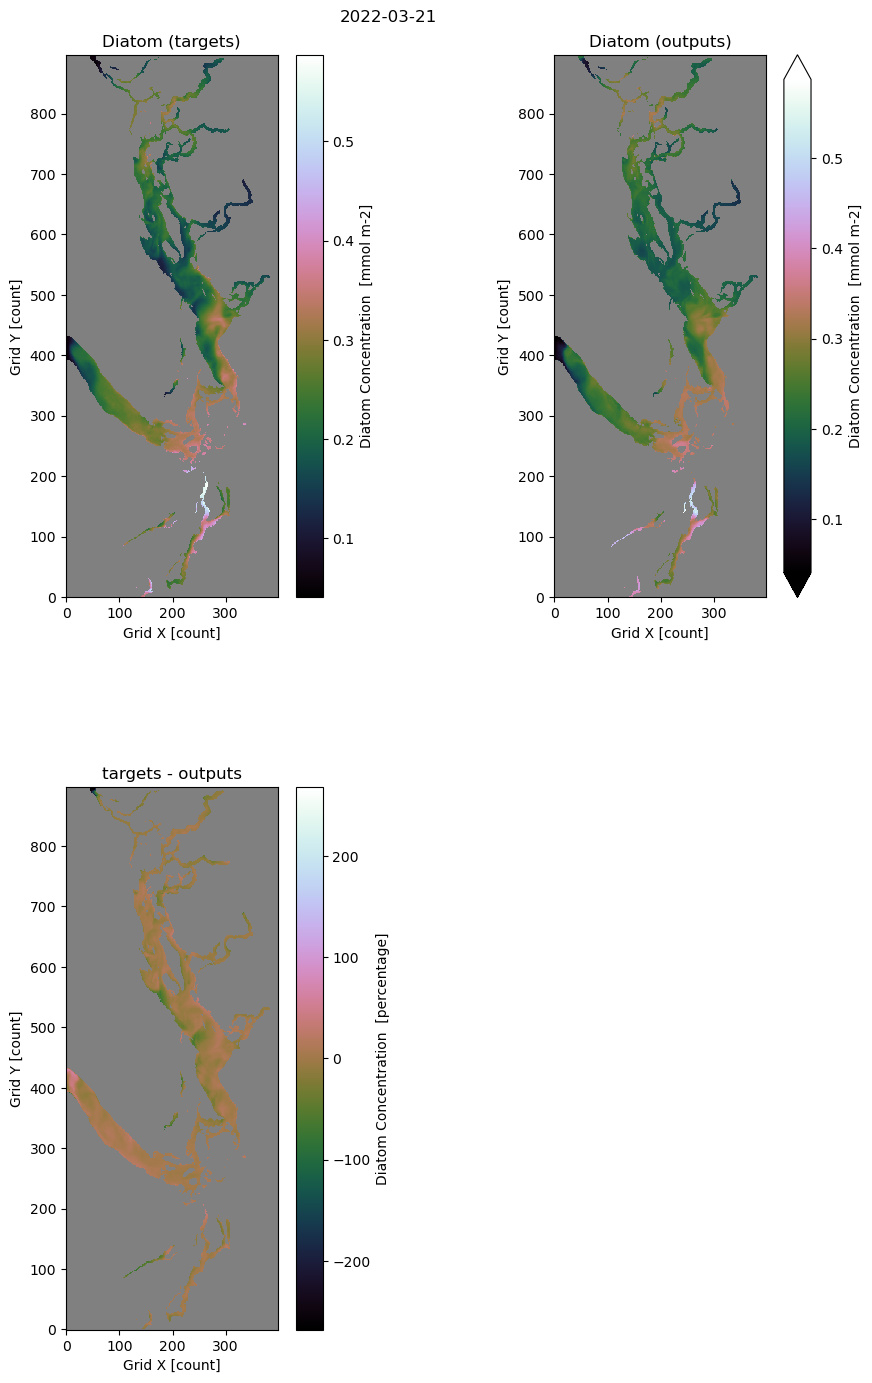

The slope of the best fitting line is  0.991
The correlation coefficient is: 0.967
 The mean square error is: 4e-05


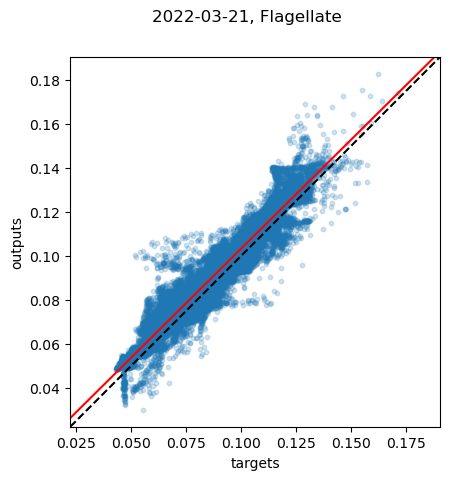

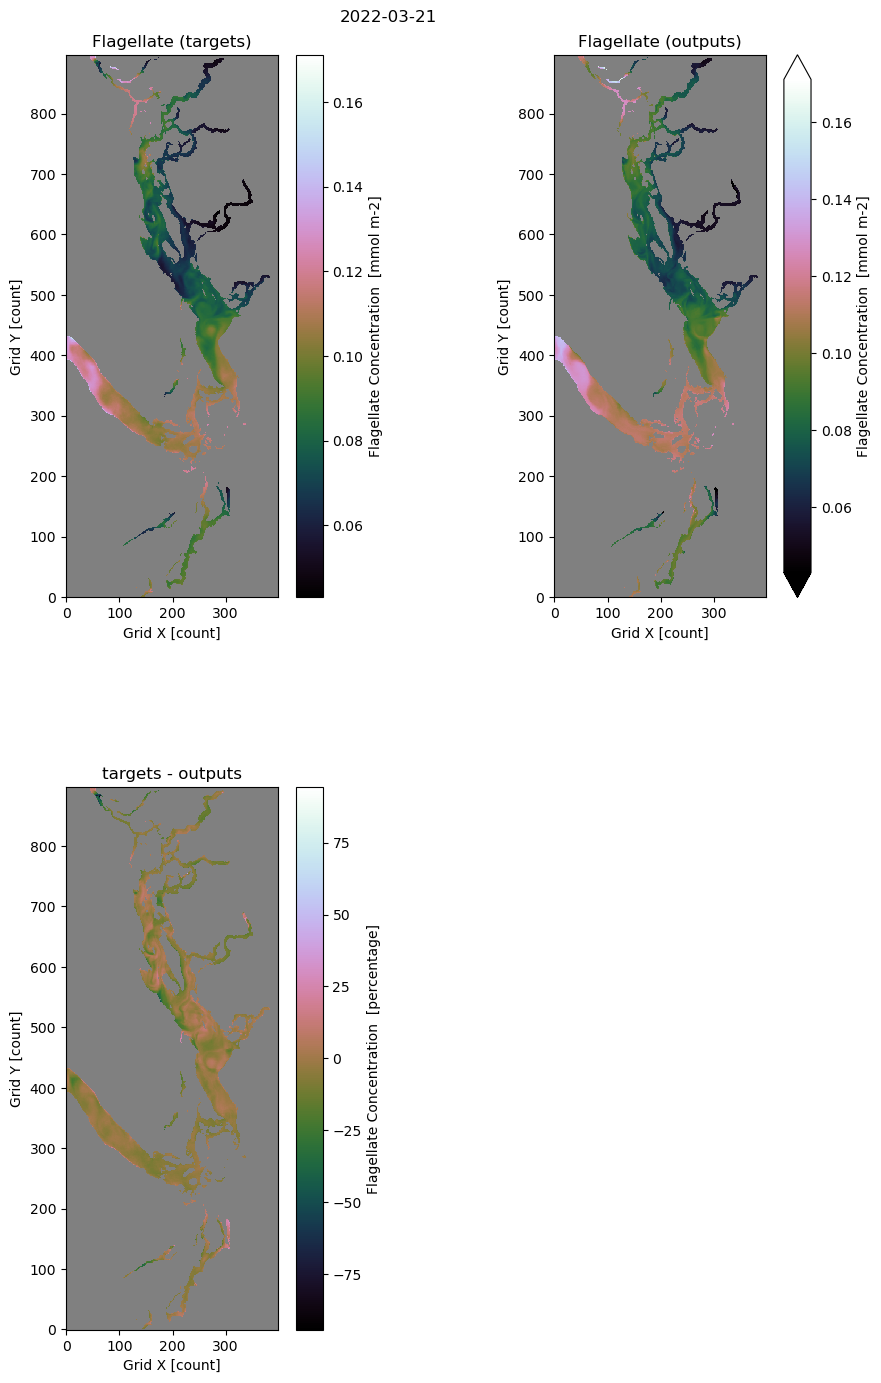

()

In [9]:
# Dataset and date
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/21mar22/SalishSea_1d_20220321_20220321_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/21mar22/SalishSea_1d_20220321_20220321_biol_T.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)

temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, diat_i, flag_i, micro_i, meso_i = datasets_preparation()

# Potential input variables
drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
nutrients = np.stack([np.ravel(sil_i), np.ravel(nitr_i), np.ravel(ammo_i)])
phyto = np.stack([np.ravel(diat_i), np.ravel(flag_i)])
zoo = np.stack([np.ravel(micro_i), np.ravel(meso_i)])

regressor2(drivers, diat_i, 'Diatom', reg_diat)
regressor2(drivers, flag_i, 'Flagellate', reg_flag)


The slope of the best fitting line is  1.038
The correlation coefficient is: 0.665
 The mean square error is: 0.00407


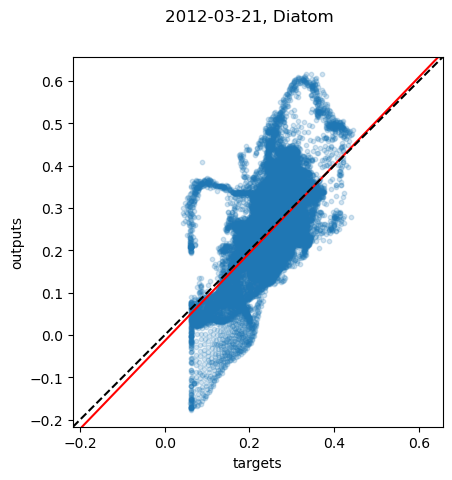

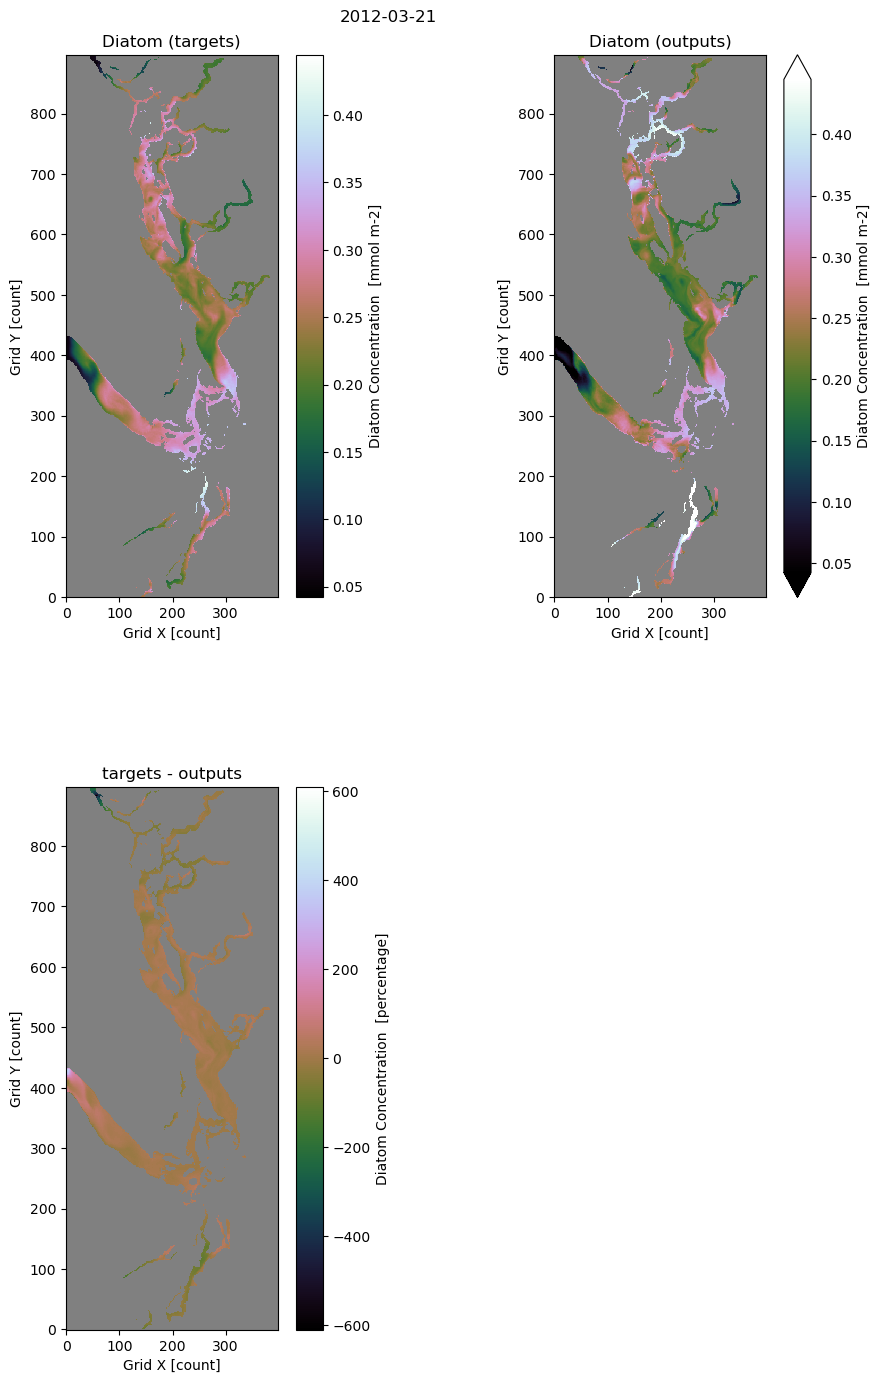

The slope of the best fitting line is  0.908
The correlation coefficient is: 0.821
 The mean square error is: 0.00063


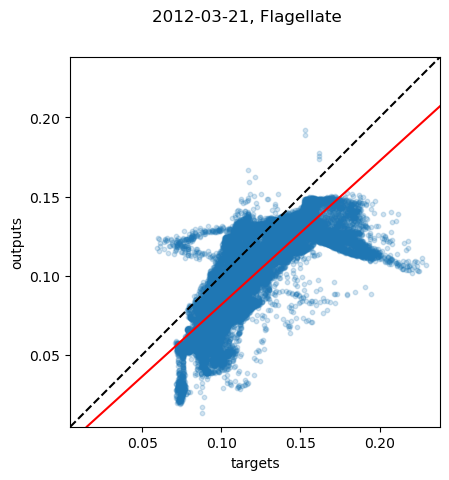

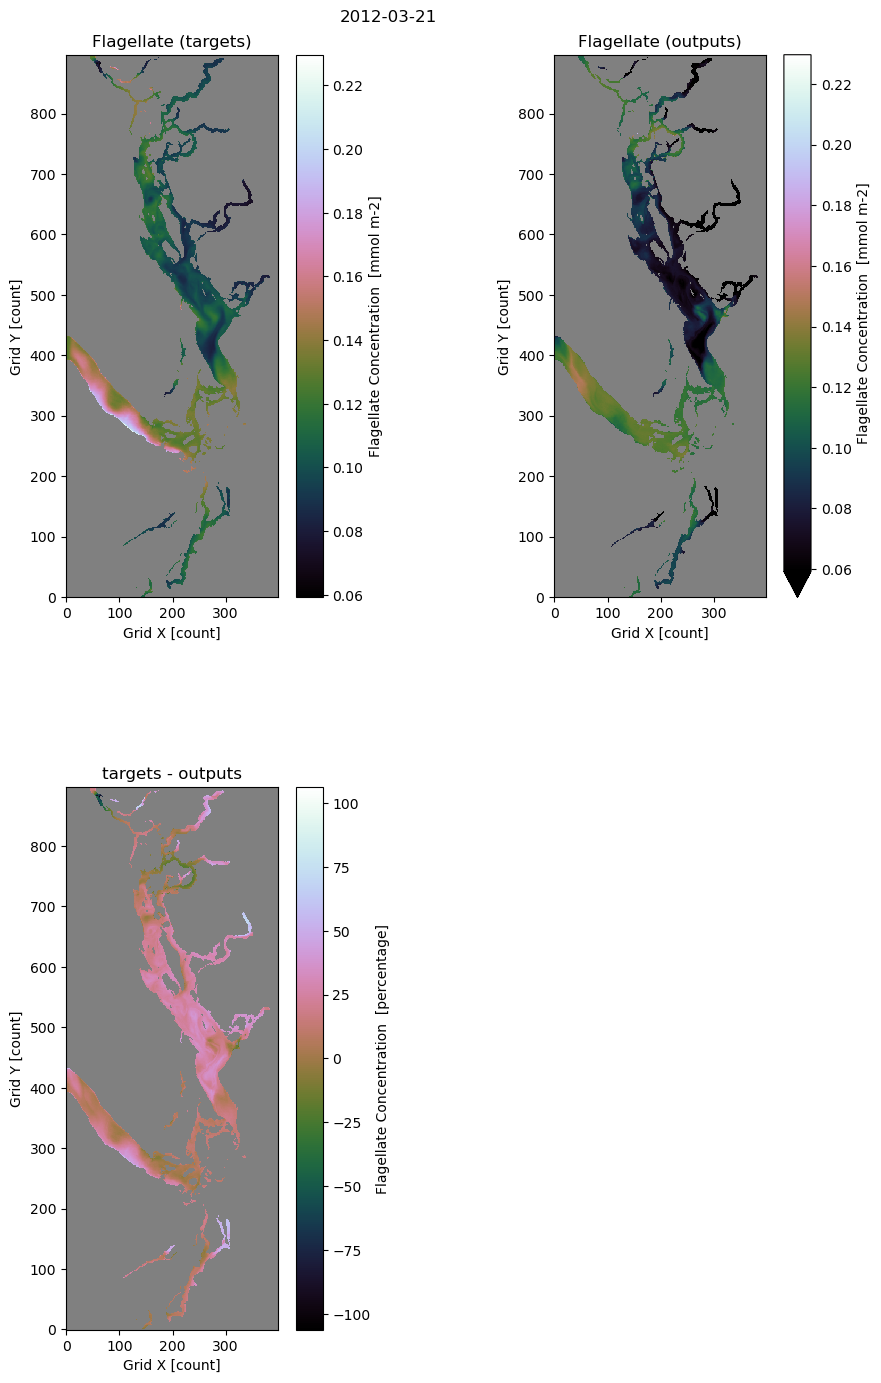

()

In [10]:
# Dataset and date
ds = xr.open_dataset ('/results2/SalishSea/nowcast-green.202111/21mar12/SalishSea_1d_20120321_20120321_grid_T.nc')
ds_bio = xr. open_dataset ('/results2/SalishSea/nowcast-green.202111/21mar12/SalishSea_1d_20120321_20120321_biol_T.nc')
date = pd.DatetimeIndex(ds['time_counter'].values)

temp_i1, temp_i2, saline_i1, saline_i2, sil_i, nitr_i, ammo_i, diat_i, flag_i, micro_i, meso_i = datasets_preparation()

# Potential input variables
drivers = np.stack([np.ravel(temp_i1), np.ravel(temp_i2), np.ravel(saline_i1), np.ravel(saline_i2)])
nutrients = np.stack([np.ravel(sil_i), np.ravel(nitr_i), np.ravel(ammo_i)])
phyto = np.stack([np.ravel(diat_i), np.ravel(flag_i)])
zoo = np.stack([np.ravel(micro_i), np.ravel(meso_i)])

regressor2(drivers, diat_i, 'Diatom', reg_diat)
regressor2(drivers, flag_i, 'Flagellate', reg_flag)